# Ideal Diode Example

The simplest way to model a solar cell is as an **ideal diode**, described by the following equation:
$$J(V,T) = J_L+J_0(\exp{\frac{qV}{nkT}}-1)$$
where $k=8.61733\times 10^{-5}$ eV/K is Boltzmann's constant, by convention $J_L$ (the light current) is negative and $J_0$ (the saturation current) is positive but strongly dependent on temperature, a dependence we can approximate as:
$$J_0 \approx B'T^{3/n}\exp{\frac{-E_{g0}}{nkT}}$$
We'll use the silicon zero-temperature bandgap, $E_{g0}=1.2$ eV, meaning we just need to fit for $B'$ in this equation.
$J_L$ is typically directly proportional to light intensity, which we will treat as fixed for this example, leaving us with two parameters to fit for: $B'$ and the ideality factor $n$.

In [1]:
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.param_list as byp
import deepdish as dd
from jupyterthemes import jtplot
jtplot.style('default')

## List the parameters
First, we list our fitting parameters.

In [2]:
fp = byp.param_list()
fp.add_fit_param(name='Bp',val_range=[10,1000],spacing='log',length=6,units='arb.')
fp.add_fit_param(name='n',val_range=[1,2],length=6)

We can inspect the `param_list` object and see what kind of information is inside...

In [3]:
fp.fit_params

[{'edges': array([   10.        ,    21.5443469 ,    46.41588834,   100.        ,
           215.443469  ,   464.15888336,  1000.        ]),
  'length': 6,
  'min_width': 1.0797751623277096,
  'name': 'Bp',
  'spacing': 'log',
  'units': 'arb.',
  'val_range': [10, 1000],
  'vals': array([  14.67799268,   31.6227766 ,   68.12920691,  146.77992676,
          316.22776602,  681.29206906])},
 {'edges': array([ 1.        ,  1.16666667,  1.33333333,  1.5       ,  1.66666667,
          1.83333333,  2.        ]),
  'length': 6,
  'min_width': 0.016666666666666666,
  'name': 'n',
  'spacing': 'linear',
  'units': 'unitless',
  'val_range': [1, 2],
  'vals': array([ 1.08333333,  1.25      ,  1.41666667,  1.58333333,  1.75      ,
          1.91666667])}]

Note that there are both `edges` and `vals` computed - the `vals` will be the values at which computations will be done, while `edges` will be the edges of the grid, used in subdivision steps later on.

Finally, we define the measurement conditions. We won't be varying light intensity here, so we only need voltage and temperature.

In [4]:
ec = ['V','T']

In [5]:
m = bym.model(params=fp,ec=ec,output_var='J')

In [6]:
m.probs.points.head(10)

,Bp,Bp_min,Bp_max,n,n_min,n_max,new,prob,num_sub
0,14.677993,10.000000,21.544347,1.083333,1.000000,1.166667,1.0,0.027778,0
1,14.677993,10.000000,21.544347,1.250000,1.166667,1.333333,1.0,0.027778,0
2,14.677993,10.000000,21.544347,1.416667,1.333333,1.500000,1.0,0.027778,0
3,14.677993,10.000000,21.544347,1.583333,1.500000,1.666667,1.0,0.027778,0
4,14.677993,10.000000,21.544347,1.750000,1.666667,1.833333,1.0,0.027778,0
5,14.677993,10.000000,21.544347,1.916667,1.833333,2.000000,1.0,0.027778,0
6,31.622777,21.544347,46.415888,1.083333,1.000000,1.166667,1.0,0.027778,0
7,31.622777,21.544347,46.415888,1.250000,1.166667,1.333333,1.0,0.027778,0
8,31.622777,21.544347,46.415888,1.416667,1.333333,1.500000,1.0,0.027778,0
9,31.622777,21.544347,46.415888,1.583333,1.500000,1.666667,1.0,0.027778,0


## Attach experimental data
This is the next step that needs to be done before adding the model as it will use the experimental conditions we enumerate here to compute simulated outputs. For our "experimental" data here, we'll actually just simulate some ideal diodes so that we can directly see how good the Bayesian approach is at recovering true underlying parameters.

We'll use $n=1.36$ and $B'=258$ as our "true" parameters. (I have no idea what "realistic" values for $B'$ would be...)

In [7]:
def compute_ID(ec,params):
    J_L = -0.03 # treat as fixed for now
    V = ec['V']
    T = ec['T']
    V_th = 8.61733e-5 * T # thermal voltage, kT/q
    n = params['n']
    Bp = params['Bp']
    J0 = Bp*T**(3/n)*math.exp(-1.2/V_th/n)
    return J_L + J0*(math.exp(V/V_th/n)-1)

V = np.arange(0,1.0,0.05)
T = [float(t) for t in np.arange(150,301,50)]
params = {'n':1.36,'Bp':258}

#data = []
#for t in T:
#    for v in V:
#        data.append([v,t,compute_ID({'V':v,'T':t},params)])
        
#data = pd.DataFrame.from_records(data=data,columns=['V','T','J'])
#dd.io.save('obs_data.h5',data)

In [8]:
m.attach_observations(fpath='obs_data.h5')

Identified experimental conditions as ['V', 'T']. If this is wrong, rerun and explicitly specify them with attach_ec (make sure they match data file columns) or remove extra columns from data file.


In [9]:
"""
import matplotlib.pyplot as plt
%matplotlib inline
leg = []
for i in range(len(T)):
    curve = data.iloc[len(V)*i:len(V)*(i+1)]
    plt.plot(curve['V'],curve['J'])
    leg.append(curve['T'].iloc[0])
plt.ylim([-0.05,0.1])
plt.legend([str(t) for t in leg])
plt.xlabel('Voltage [V]')
plt.ylabel('Current')
plt.show()
"""

"\nimport matplotlib.pyplot as plt\n%matplotlib inline\nleg = []\nfor i in range(len(T)):\n    curve = data.iloc[len(V)*i:len(V)*(i+1)]\n    plt.plot(curve['V'],curve['J'])\n    leg.append(curve['T'].iloc[0])\nplt.ylim([-0.05,0.1])\nplt.legend([str(t) for t in leg])\nplt.xlabel('Voltage [V]')\nplt.ylabel('Current')\nplt.show()\n"

In [10]:
#m.obs_data.head()

## Attach model
Now we add the function that gives the modeled data - in this case, the `compute_ID` function we just defined above.

In [11]:
m.attach_model(mode='function',func_name=compute_ID)
#m.attach_model(mode='file',fpath='model_data.h5')

That's it! When that function is called, `bayesim` also generates the full table of modeled data at all experimental conditions in the observed data we attached before. Check it out:

In [12]:
m.model_data.head(10)

,Bp,J,T,V,n
0,14.677993,-0.03,150.0,0.00,1.083333
1,14.677993,-0.03,150.0,0.05,1.083333
2,14.677993,-0.03,150.0,0.10,1.083333
3,14.677993,-0.03,150.0,0.15,1.083333
4,14.677993,-0.03,150.0,0.20,1.083333
5,14.677993,-0.03,150.0,0.25,1.083333
6,14.677993,-0.03,150.0,0.30,1.083333
7,14.677993,-0.03,150.0,0.35,1.083333
8,14.677993,-0.03,150.0,0.40,1.083333
9,14.677993,-0.03,150.0,0.45,1.083333


In [13]:
m.calc_model_gradients()

In [14]:
check=m.model_data.loc[8::80]

## Drop that Bayes!

In [15]:
m.probs.uniformize()
m.run()

(0, V      0.450000
T    300.000000
J      0.010884
Name: 69, dtype: float64)
(1, V      0.55000
T    250.00000
J     -0.01835
Name: 51, dtype: float64)
(2, V      0.80000
T    250.00000
J     59.13164
Name: 56, dtype: float64)
(3, V      0.20
T    200.00
J     -0.03
Name: 24, dtype: float64)
(4, V      0.500000
T    200.000000
J     -0.029997
Name: 30, dtype: float64)
(5, V      0.300000
T    250.000000
J     -0.029998
Name: 46, dtype: float64)
Fed in 6 points and now time to subdivide!


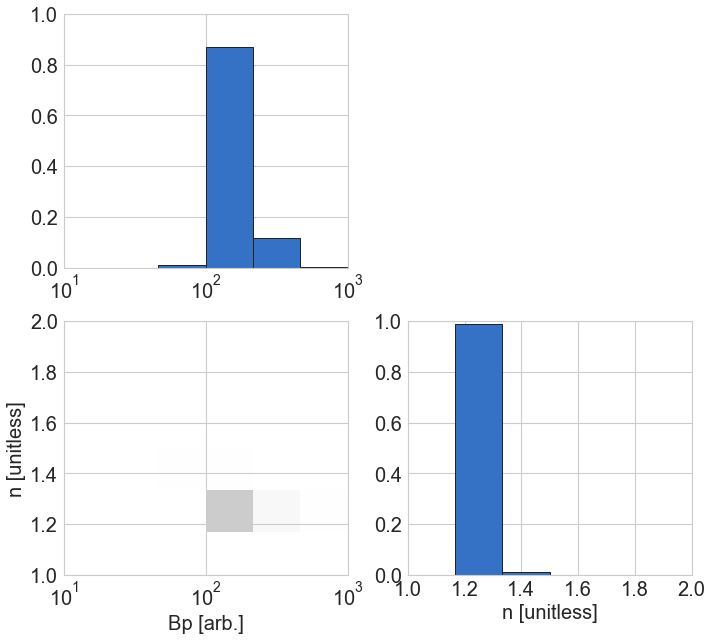

In [16]:
m.probs.visualize()

In [17]:
#m.probs.visualize(just_grid=True)

In [18]:
m.probs.most_probable(10)

,Bp,Bp_min,Bp_max,n,n_min,n_max,new,prob,num_sub,start_ind,end_ind
19,146.779927,100.000000,215.443469,1.250000,1.166667,1.333333,1.0,8.687278e-01,0,1520,1599
25,316.227766,215.443469,464.158883,1.250000,1.166667,1.333333,1.0,1.178347e-01,0,2000,2079
14,68.129207,46.415888,100.000000,1.416667,1.333333,1.500000,1.0,8.838945e-03,0,1120,1199
20,146.779927,100.000000,215.443469,1.416667,1.333333,1.500000,1.0,2.636202e-03,0,1600,1679
31,681.292069,464.158883,1000.000000,1.250000,1.166667,1.333333,1.0,1.861234e-03,0,2480,2559
15,68.129207,46.415888,100.000000,1.583333,1.500000,1.666667,1.0,6.321626e-05,0,1200,1279
26,316.227766,215.443469,464.158883,1.416667,1.333333,1.500000,1.0,2.829442e-05,0,2080,2159
13,68.129207,46.415888,100.000000,1.250000,1.166667,1.333333,1.0,6.538611e-06,0,1040,1119
21,146.779927,100.000000,215.443469,1.583333,1.500000,1.666667,1.0,2.423124e-06,0,1680,1759
32,681.292069,464.158883,1000.000000,1.416667,1.333333,1.500000,1.0,2.589165e-07,0,2560,2639


In [19]:
m.model_data.head()

,Bp,J,T,V,n,deltas,error
0,14.677993,-0.03,150.0,0.00,1.083333,0.0,0.0
1,14.677993,-0.03,150.0,0.05,1.083333,0.0,0.0
2,14.677993,-0.03,150.0,0.10,1.083333,0.0,0.0
3,14.677993,-0.03,150.0,0.15,1.083333,0.0,0.0
4,14.677993,-0.03,150.0,0.20,1.083333,0.0,0.0


In [20]:
m.subdivide(threshold_prob=0.01)

2 box(es) with probability > 0.01 and 6 neighboring boxes subdivided!
New model points to simulate are saved in the file new_sim_points_1.h5.


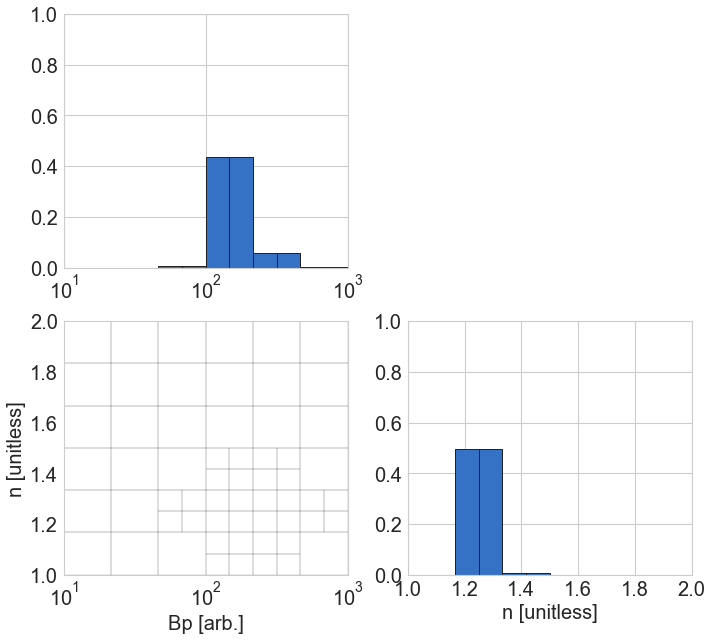

In [21]:
m.probs.visualize(just_grid=True)

In [22]:
new_sims = dd.io.load('new_sim_points_1.h5')

In [23]:
#new_sims.head()

In [24]:

data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.param_names])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.param_names)
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data.h5',new_sim_data)


In [25]:
m.save_state()
#m = bym.model(load_state=True)

In [26]:
m.attach_model(mode='add',fpath='new_sim_data.h5')

In [27]:
m.calc_model_gradients()

../../bayesim/model.py:712: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  deltas[[delta_inds_to_update]] = deltas_temp[[delta_inds_to_update]]


In [28]:
check2 = m.model_data.loc[8::80]

In [41]:
check.iloc[12:25]

,Bp,J,T,V,n,deltas
968,68.129207,-0.03,150.0,0.4,1.083333,3.563122e-15
1048,68.129207,-0.03,150.0,0.4,1.250000,2.903511e-13
1128,68.129207,-0.03,150.0,0.4,1.416667,9.263749e-12
1208,68.129207,-0.03,150.0,0.4,1.583333,1.505624e-10
1288,68.129207,-0.03,150.0,0.4,1.750000,1.482939e-09
1368,68.129207,-0.03,150.0,0.4,1.916667,1.896805e-09
1448,146.779927,-0.03,150.0,0.4,1.083333,7.670947e-15
1528,146.779927,-0.03,150.0,0.4,1.250000,6.255482e-13
1608,146.779927,-0.03,150.0,0.4,1.416667,1.995814e-11
1688,146.779927,-0.03,150.0,0.4,1.583333,3.243768e-10


In [42]:
check2.iloc[12:25]

,Bp,J,T,V,deltas,error,n
968,68.129207,-0.03,150.0,0.4,3.563122e-15,3.563122e-15,1.083333
1048,68.129207,-0.03,150.0,0.4,9.263749e-12,9.263749e-12,1.416667
1128,68.129207,-0.03,150.0,0.4,1.505624e-10,1.505624e-10,1.583333
1208,68.129207,-0.03,150.0,0.4,1.482939e-09,1.482939e-09,1.750000
1288,68.129207,-0.03,150.0,0.4,1.896805e-09,1.896805e-09,1.916667
1368,146.779927,-0.03,150.0,0.4,3.243768e-10,3.243768e-10,1.583333
1448,146.779927,-0.03,150.0,0.4,3.194896e-09,3.194896e-09,1.750000
1528,146.779927,-0.03,150.0,0.4,4.086542e-09,4.086542e-09,1.916667
1608,316.227766,-0.03,150.0,0.4,6.988486e-10,6.988486e-10,1.583333
1688,316.227766,-0.03,150.0,0.4,6.883195e-09,6.883195e-09,1.750000


In [29]:
#m.probs.uniformize()

In [30]:
m.run(th_pm=0.95,th_pv=0.02)

(0, V      0.500000
T    250.000000
J     -0.027886
Name: 50, dtype: float64)
(1, V      0.650000
T    300.000000
J     12.049155
Name: 73, dtype: float64)
(2, V      0.550000
T    300.000000
J      0.672743
Name: 71, dtype: float64)
(3, V      0.300000
T    300.000000
J     -0.029426
Name: 66, dtype: float64)
(4, V      0.45
T    150.00
J     -0.03
Name: 9, dtype: float64)
(5, V      0.65
T    150.00
J     -0.03
Name: 13, dtype: float64)
(6, V      0.10
T    200.00
J     -0.03
Name: 22, dtype: float64)
Fed in 7 points and now time to subdivide!


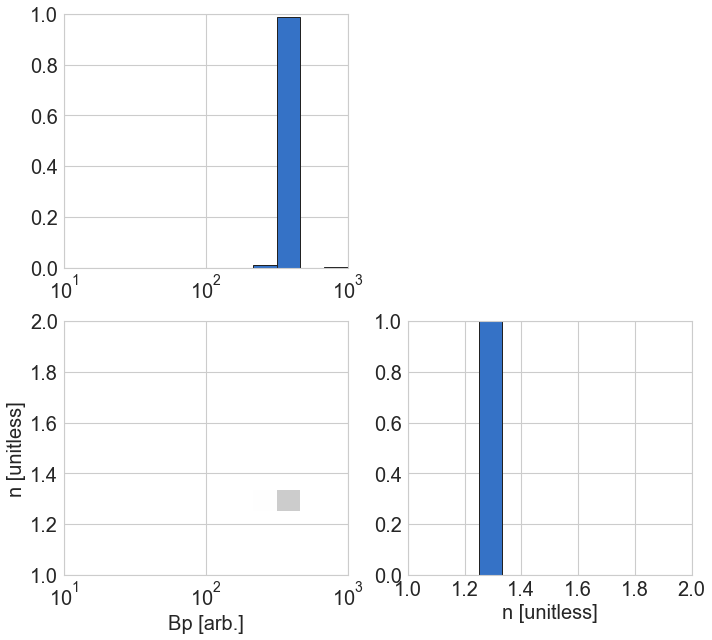

In [31]:
m.probs.visualize()

In [32]:
m.probs.visualize(just_grid=True)

KeyboardInterrupt: 

In [ ]:
#m.probs.most_probable(10)

In [ ]:
#m.save_state()

In [ ]:
#m = bym.model(state_file='bayesim_state.h5')

In [ ]:
from copy import deepcopy
subset = deepcopy(m.model_data.loc[m.model_data_ecgrps.groups[(0.7, 200.0)]])
subset.sort_values(m.param_names,inplace=True)
subset.drop_duplicates(subset=m.param_names+m.ec_names,inplace=True)
subset.reset_index(inplace=True)
subset.head(10)

In [ ]:
mat_shape = []
param_vals = {}
pvals_indices = {}
for param in m.fit_params:
    min_edge = param['edges'][0]
    max_edge = param['edges'][-1]
    length = 2*param['length']*2**m.probs.num_sub+1
    if param['spacing']=='linear':
        param_vals[param['name']] = np.linspace(min_edge,max_edge,length)[1:-1:2]
    elif param['spacing']=='log':
        param_vals[param['name']] = np.logspace(np.log10(min_edge),np.log10(max_edge),length)[1:-1:2]
    mat_shape.append(len(param_vals[param['name']]))
    pvals_indices[param['name']] = {param_vals[param['name']][i]:i for i in range(len(param_vals[param['name']]))}

In [ ]:
mat = np.zeros(mat_shape)

In [ ]:
ind_lists = {p:[] for p in m.param_names}
ind_lists

In [ ]:
delta_inds_to_update = []
for row in subset.iterrows():
    slices = []
    param_point = m.probs.points.loc[row[0]]
    if param_point['new']==True:
        delta_inds_to_update.append(row[1]['index'])
    p_ind = 0
    for param in m.param_names:
        min_val = param_point[param+'_min']
        max_val = param_point[param+'_max']
        inds = [pvals_indices[param][v] for v in param_vals[param] if v>min_val and v<max_val]
        slices.append(slice(min(inds),max(inds)+1,None))
        ind_lists[param].append(inds[0])
        p_ind = p_ind+1
    output_val = row[1][m.output_var]
    mat[slices] = output_val

In [ ]:
m.probs.visualize(just_grid=True)

In [ ]:
m.probs.points[m.param_names].head(15)